<h1 align="center">PART II</h1>
<h1 align="center">Sentiment Analysis Classifications - Review and Comparison</h1>

First, we needed to create vector words. For simplicity, we used a pre-trained model.

Google was able to teach the Word2Vec model on a massive Google News dataset that contained over 100 billion different words! Google has created [3 million vector words](https://code.google.com/archive/p/word2vec/#Pre-trained_word_and_phrase_vectors) from this model, each with a dimension of 300. We would use these vectors.

#### How word2vec works:

The idea behind word2vec is that:

    Take a 3 layer neural network. (1 input layer + 1 hidden layer + 1 output layer)
    Feed it a word and train it to predict its neighbouring word.
    Remove the last (output layer) and keep the input and hidden layer.
    Now, input a word from within the vocabulary. The output given at the hidden layer is the ‘word embedding’ of the input word.
    
Two popular examples of methods of learning word embeddings from text include:

    Word2Vec
    GloVe

To get started, let's download the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Next, we will load the sample data we processed in the previous part:

In [3]:
with open('documents.pql', 'rb') as f:
     docs = pickle.load(f)

In [4]:
print("Number of documents:", len(docs))

Number of documents: 38544


Next operation may take some time, as the model contains 3 000 000 words, so we will get a 3 000 000 x 300 embedding matrix that contains all the values of the word vectors.

In [5]:
model = word2vec.KeyedVectors.load_word2vec_format('model/GoogleNews-vectors-negative300.bin', binary=True)

Now let's get a list of all the words from our dictionary:

In [7]:
words = list(model.index_to_key)

Just to make sure everything is loaded correctly, we can look at the dimensions of the dictionary list and the embedding matrix:

In [9]:
print(words[:50], "\n\nTotal words:", len(words), "\n\nWord-Vectors shape:", model.vectors.shape)

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out'] 

Total words: 3000000 

Word-Vectors shape: (3000000, 300)


We can also find a word like "football" in our word list and then access the corresponding vector through the embedding matrix:

In [10]:
print(model['football'])

[-9.76562500e-02  3.19824219e-02  2.57812500e-01 -4.15039062e-02
  1.01562500e-01 -1.00585938e-01  1.46484375e-01 -1.99218750e-01
  1.53320312e-01  6.34765625e-02  8.39843750e-02 -3.00781250e-01
  6.34765625e-02  2.08984375e-01 -2.11914062e-01  1.88476562e-01
 -8.34960938e-02  3.28125000e-01  2.79296875e-01 -1.40625000e-01
 -1.68945312e-01  2.04101562e-01  4.90722656e-02 -6.98852539e-03
  9.42382812e-02  9.84191895e-04  3.12500000e-02  2.48046875e-01
  3.35937500e-01  2.63671875e-01  5.68847656e-02  3.04687500e-01
  1.21582031e-01 -1.97265625e-01  1.72119141e-02  9.96093750e-02
  2.27539062e-01 -1.20605469e-01  1.23535156e-01  3.78906250e-01
  2.36816406e-02 -1.86523438e-01  6.29882812e-02  1.52343750e-01
  3.73535156e-02 -1.69921875e-01  1.06445312e-01 -4.98046875e-02
 -6.20117188e-02  1.68945312e-01  4.41894531e-02  2.78320312e-02
 -1.10839844e-01  4.49218750e-02  2.78320312e-02 -4.45312500e-01
  3.49121094e-02 -6.22558594e-02 -3.93066406e-02 -2.01171875e-01
 -3.04687500e-01 -1.00585

<h2 align="center">Word Average Embedding Model</h2>

Well, let's start analyzing our vectors. Our first approach will be the **word average embedding model**. 

The essence of this naive approach is to take the average of all word vectors from a sentence to get one 300-dimensional vector that represents the tone of the whole sentence that we feed the model and try to get some quick result.

We didn't have to put a try/except, but even though I cleaned up our sample, there were a couple of words left after the processing that needed to be searched for and removed.

In [11]:
def sent_embed(words, docs):
    x_sent_embed, y_sent_embed = [], []
    count_words, count_non_words = 0, 0  
    
    # recover the embedding of each sentence with the average of the vector that composes it
    # sent - sentence, state - state of the sentence (pos/neg)
    for sent, state in docs:
        # average embedding of all words in a sentence
        sent_embed = []
        for word in sent:
            try:
                # if word is present in the dictionary - add its vector representation
                count_words += 1
                sent_embed.append(model[word])
            except KeyError:
                # if word is not in the dictionary - add a zero vector
                count_non_words += 1
                sent_embed.append([0] * 300)
        
        # add a sentence vector to the list
        x_sent_embed.append(np.mean(sent_embed, axis=0).tolist())
        
        # add a label to y_sent_embed
        if state == 'pos': y_sent_embed.append(1)
        elif state == 'neg': y_sent_embed.append(0)
            
    print(count_non_words, "out of", count_words, "words were not found in the vocabulary.")
    
    return x_sent_embed, y_sent_embed

In [12]:
x, y = sent_embed(words, docs)

48251 out of 1802696 words were not found in the vocabulary.


<h2 align="center">Cosine Similarity</h2>

To measure the similarity of 2 words, we need a way to measure the degree of similarity between 2 embedding vectors for these 2 words. Given 2 vectors $u$ and $v$, cosine similarity is determined as follows:

$$\text{cosine_similarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta)$$

where: 

* $u.v$ - dot product (or inner product) of two vectors;

* $||u||_2$ - norm (or length) of the vector $u$;
    
    * **Note**: norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$)

* $\theta$ is the angle between $u$ and $v$. 

This similarity depends on the angle between $u$ and $v$. If $u$ and $v$ are very similar, their cosine similarity will be close to 1; if they are dissimilar, the cosine similarity will take a smaller value. 

**`cosine_similarity()`** is a method that used to estimate the similarity between word vectors.

In [13]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    
    # compute the dot product between u and v
    dot = np.dot(u,v)
    
    # compute the L2 norm of u
    norm_u = np.sqrt(sum(u**2))
    
    # Compute the L2 norm of v
    norm_v = np.sqrt(sum(v**2))
    
    # Compute the cosine similarity defined by formula above
    cosine_similarity = dot/(norm_u*norm_v)
    
    return cosine_similarity

<h2 align="center">Split Corpus</h2>

Now, for further work, we will divide our corpus for training, testing and development sets:

In [21]:
from sklearn.model_selection import train_test_split

# train test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# train dev
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [22]:
print('Length of x_train:', len(x_train), '| Length of y_train:', len(y_train))
print('Length of x_test:  ', len(x_test), '| Length of y_test: ', len(y_test))
print('Length of x_val:   ', len(x_val), '| Length of y_val:  ', len(y_val))

Length of x_train: 24668 | Length of y_train: 24668
Length of x_test:   7709 | Length of y_test:  7709
Length of x_val:    6167 | Length of y_val:   6167


In [23]:
print("Shape of x_train set:", np.array(x_train).shape)

Shape of x_train set: (24668, 300)


<h2 align="center">Visualization of Classification Report</h2>

We will need these methods when we start to visualize our data, so we will write them now.

The following function takes the conclusion of the `classification_report` function as an argument and plots the results ( function is based on [this](https://stackoverflow.com/a/31689645/14467732) solution).

In [24]:
def plot_classification_report(classification_report, title='Classification Report', cmap='RdBu'):
    
    lines = classification_report.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    
    for line in lines[2 : (len(lines) - 5)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

This function is designed to create a heatmap with text in each cell using the matplotlib library (code based on idea from [here](https://stackoverflow.com/a/16124677/14467732)):

In [25]:
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle='dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # add color bar
    plt.colorbar(c)

    # add text in each cell 
    show_val(c)

    # proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm_to_inch(figure_width, figure_height))

This function just inserts the text into the cells of the heatmap (idea is taken from [here](https://stackoverflow.com/a/25074150/14467732)):

In [26]:
def show_val(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

The last auxiliary function is intended to specify the size of the figure in centimeters in matplotlib, because by default there is only the method `set_size_inches`, therefore, we will convert inches to centimeters and use this method:

In [27]:
def cm_to_inch(*dim):
    inch = 2.54
    return tuple(i/inch for i in dim[0]) if type(dim[0]) == tuple else tuple(i/inch for i in dim)

**Note:** To better understand the following classifiers, I advise you to read [this article](https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222) or other similar ones that you will find on the Internet.

<h2 align="center">KNN Model</h2>

The K-nearest neighbors (KNN) algorithm is a type of supervised machine learning algorithms. KNN is extremely easy to implement in its most basic form, and yet performs quite complex classification tasks.  It is a lazy learning algorithm since it doesn't have a specialized training phase. Rather, it uses all of the data for training while classifying a new data point or instance.  KNN is also a non-parametric learning algorithm, which means that it doesn't assume anything about the underlying data.


KNN  algorithm simply calculates the distance of a new data point to all other training data points. The distance can be of any type e.g Euclidean or Manhattan etc. It then selects the K-nearest data points, where K can be any integer. Finally it assigns the data point to the class to which the majority of the K data points belong.

Now, let's build KNN classifier model.

First, we import the `KNeighborsClassifier` module and create KNN classifier object by passing argument number of neighbors in `KNeighborsClassifier()` function. Then, fit our model on the train set using `fit()` and perform prediction on the test set using `predict()`.

One way to help find the best value of neighbors is to plot the graph of neighbor value and the corresponding error rate for the dataset. We will plot the mean error for the predicted values of test set for all the neighbor values between 1 and 25.
To do so, let's first calculate the mean of error for all the predicted values where neighbor ranges from 1 and 25:

In [28]:
from sklearn.neighbors import KNeighborsClassifier

error = []

# calculating error for neighbor values between 1 and 25
for i in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

The next step is to plot the error values against neighbor values:

Text(0, 0.5, 'Mean Error')

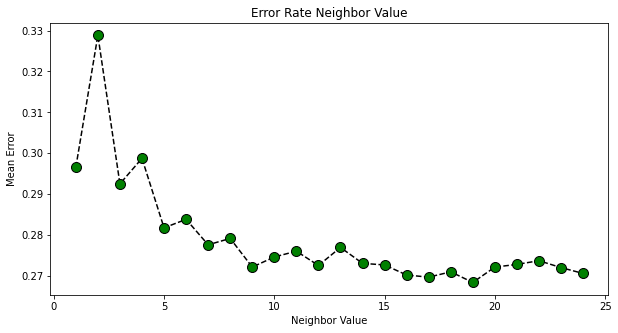

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), error, color='black', linestyle='dashed', marker='o', markerfacecolor='green', markersize=10)
plt.title('Error Rate Neighbor Value')
plt.xlabel('Neighbor Value')
plt.ylabel('Mean Error')

As we can see, it is best to take k=19, but still mean error a little higher than normal.

In [30]:
# create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=19, weights='distance')

# train the classifier using the training sets
knn.fit(x_train, y_train)

# predict the response for test dataset
y_pred = knn.predict(x_test)

print("Nearest Neighbors Result (k=19):\n" + '-' * 35)
print("Accuracy Score (k=19):", str(round(knn.score(x_test, y_test) * 100, 2)) + '%')
print("Accuracy (x_train, y_train):", str(round(knn.score(x_train, y_train), 4) * 100) + '%')

Nearest Neighbors Result (k=19):
-----------------------------------
Accuracy Score (k=19): 75.41%
Accuracy (x_train, y_train): 100.0%


The accuracy of the model is good, we can work with it.

Now let's explore our KNN Classification results with help of `classification_report` function from sklearn.metrics:

In [31]:
from sklearn.metrics import classification_report
print('\nClassification KNN:\n', classification_report(y_test, knn.predict(x_test)))


Classification KNN:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69      3331
           1       0.75      0.84      0.80      4378

    accuracy                           0.75      7709
   macro avg       0.75      0.74      0.74      7709
weighted avg       0.75      0.75      0.75      7709



Now finally let's visualize our classification report:

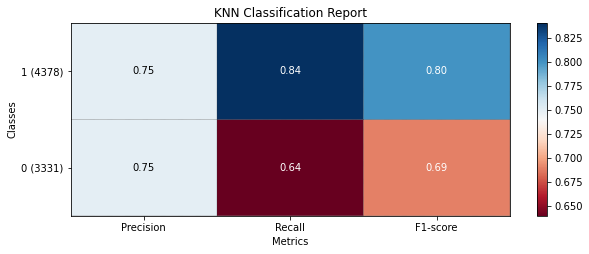

In [32]:
plot_classification_report(classification_report(y_test, knn.predict(x_test)), title='KNN Classification Report')

<h2 align="center">Logistic Regression</h2>

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [33]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='liblinear', multi_class='ovr', n_jobs=1)
logit.fit(x_train, y_train)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [34]:
print("Accuracy Score:", str(round(logit.score(x_test, y_test) * 100, 2)) + '%')

Accuracy Score: 80.58%


In [35]:
print('\nClassification Logistic Regression:\n', classification_report(y_test, logit.predict(x_test)))


Classification Logistic Regression:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      3331
           1       0.82      0.84      0.83      4378

    accuracy                           0.81      7709
   macro avg       0.80      0.80      0.80      7709
weighted avg       0.81      0.81      0.81      7709



Now let's visualize our classification report:

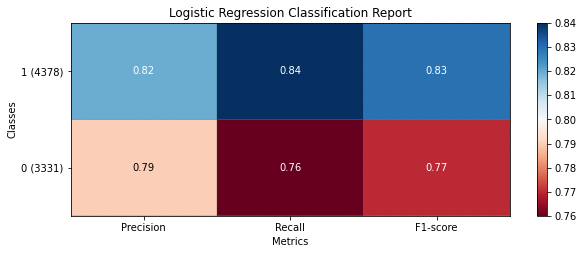

In [36]:
plot_classification_report(classification_report(y_test, logit.predict(x_test)), title='Logistic Regression Classification Report')

<h2 align="center">Random Forest Classifier</h2>

The Random forest or Random Decision Forest is a supervised Machine learning algorithm used for classification, regression, and other tasks using decision trees.

The Random forest classifier creates a set of decision trees from a randomly selected subset of the training set. It is basically a set of decision trees (DT) from a randomly selected subset of the training set and then It collects the votes from different decision trees to decide the final prediction.

In [37]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

print("Accuracy Score:", str(round(clf.score(x_test, y_test), 4) * 100) + '%')

Accuracy Score: 79.54%


In [38]:
print('\nClassification Random Forest:\n', classification_report(y_test, clf.predict(x_test)))


Classification Random Forest:
               precision    recall  f1-score   support

           0       0.81      0.69      0.74      3331
           1       0.79      0.88      0.83      4378

    accuracy                           0.80      7709
   macro avg       0.80      0.78      0.79      7709
weighted avg       0.80      0.80      0.79      7709



Now let's visualize our classification report:

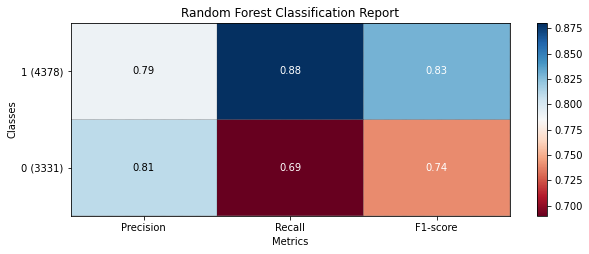

In [39]:
plot_classification_report(classification_report(y_test, clf.predict(x_test)), title='Random Forest Classification Report')

<h2 align="center">SVM Model</h2>

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

    + Effective in high dimensional spaces.

    + Still effective in cases where number of dimensions is greater than the number of samples.

    + Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

    + Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

    - If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

    - SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).
    
You can read more about it [here](https://en.wikipedia.org/wiki/Support-vector_machine).

In [41]:
from sklearn import svm

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
SVM.fit(x_train[int(len(x_train)*0.75):], y_train[int(len(y_train)*0.75):])

print("Accuracy Score:", str(round(SVM.score(x_test[int(len(x_test)*0.75):], y_test[int(len(y_test)*0.75):]), 4) * 100) + '%')

Accuracy Score: 79.36%


In [42]:
print('\nClassification SVM:\n', classification_report(y_test, SVM.predict(x_test)))


Classification SVM:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77      3331
           1       0.82      0.84      0.83      4378

    accuracy                           0.80      7709
   macro avg       0.80      0.80      0.80      7709
weighted avg       0.80      0.80      0.80      7709



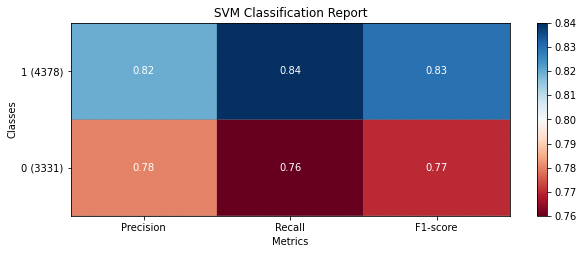

In [43]:
plot_classification_report(classification_report(y_test, SVM.predict(x_test)), title='SVM Classification Report')

<h2 align="center">Comparison of Models</h2> 

A useful tool when predicting the probability of a binary outcome is the Receiver Operating Characteristic curve, or ROC curve.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It describes how good the model is at predicting the positive class when the actual outcome is positive.

The false positive rate is calculated as the number of false positives divided by the sum of the number of false positives and the number of true negatives.

It is also called the false alarm rate as it summarizes how often a positive class is predicted when the actual outcome is negative.

To make this clear:
* Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
* Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

In [44]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

fprKNN, tprKNN, thresholdsKNN = metrics.roc_curve(y_test, knn.predict_proba(x_test)[:, 1])
fprLR, tprLR, thresholdsLR = metrics.roc_curve(y_test, logit.predict_proba(x_test)[:, 1])
fprCLF, tprCLF, thresholdCLF = metrics.roc_curve(y_test, clf.predict_proba(x_test)[:, 1])
fprSVM, trpSVM, thresholdSVM = metrics.roc_curve(y_test, SVM.predict_proba(x_test)[:, 1])

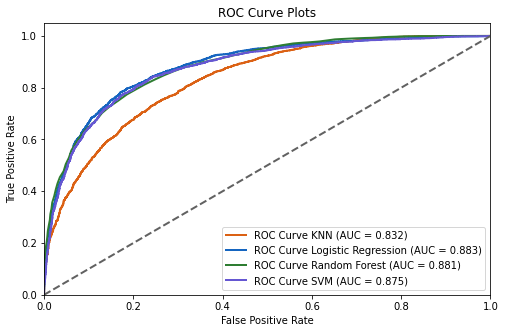

In [45]:
linewidth = 2
plt.figure(figsize=(8, 5))

plt.plot(fprKNN, tprKNN, color='#db6114', lw=linewidth, label='ROC Curve KNN (AUC = %0.3f)' % auc(fprKNN, tprKNN))
plt.plot(fprLR, tprLR, color='#1565c0', lw=linewidth, label='ROC Curve Logistic Regression (AUC = %0.3f)' % auc(fprLR, tprLR))
plt.plot(fprCLF, tprCLF, color='#2e7d32',lw=linewidth, label='ROC Curve Random Forest (AUC = %0.3f)' % auc(fprCLF, tprCLF))
plt.plot(fprSVM, trpSVM, color='#6557d2',lw=linewidth, label='ROC Curve SVM (AUC = %0.3f)' % auc(fprSVM, trpSVM))
plt.plot([0, 1], [0, 1], color='#616161', lw=linewidth, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Plots')
plt.legend(loc="lower right")

plt.show()

Based on these data, we can conclude that the best model so far is a **Logistic Regression Model** with `AUC = 88.3%` and `Accuracy Score = 80.58%`.

Let's save this model:

In [46]:
with open('LRModel.pickle', 'wb') as m:
    pickle.dump(logit, m)

Let's check if everything is loaded correctly:

In [47]:
with open('LRModel.pickle', 'rb') as m:
     rf = pickle.load(m)

print("Logistic Regression Accuracy Score:", str(round(clf.score(x_test, y_test), 4) * 100) + '%')

Logistic Regression Accuracy Score: 79.54%


In the next part we will finally try the **LSTM** neural network, which takes a sequence of words and remembers the order of words in a sentence, this approach should give us the best results.